<a href="https://colab.research.google.com/github/plnu-biomechanics/kin6015/blob/main/notebooks/kin6015_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://www.pointloma.edu/sites/default/files/styles/basic_page/public/images/PLNU_Biomechanics_Lab_green_yellowSD_HiRes.png" width=400>

## **KIN 6015 Biomechanical Basis of Human Movement**
Instructor: Arnel Aguinaldo, PhD

**Lab 4 Data Processing**

In this lab, running and walking gait analysis data was collected with muscle activation patterns for the rectus femoris, hamstring, and gastroc-soleus complex using surface electromyography (EMG). Inverse kinematics (IK) and kinetics via inverse dynamics as well as rectified EMG were estimated using Visual3D. The data were then exported as text (*.txt) files and uploaded to the class repository in the lab's [GitHub](https://github.com/plnu-biomechanics).

To further process the data for this lab, follow the steps in this **Colab notebook**, which contains instructions and sample code on how to wrangle and analyze the data.


### Create your own Colab Notebook

1. Go to **File -> New notebook in Drive** to open a new notebook in your Python environment:<br>
<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/file_notebook.png" width=450>

2. Rename your Colab notebook using this naming format: **lastname_group_lab#.ipynb** (e.g., "aguinaldo_targaryen_lab1.ipynb")
3. Click on the **+ Code** option above to insert a new code cell: <br>
<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/addcode.png" width=280>

4. The data you will parse and analyze for this lab will be copied from the lab's GitHub and temporarily stored in your Colab's runtime directory, which can be accessed by clicking on the folder icon in the left menu:<br>
<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/colab_folder.png" width=400>

5. Copy the following lines of code to import the packages needed for this analysis and to load the data files into your working directory. Be sure to update the `GROUP` variable with your group's name. **Note**: These files are "runtime" access only, meaning they are only temporarily stored in your working directory and show up when your notebook is in session. However, the following code cell allows you to clone the zipped files to the working directory each time it is executed.


In [9]:
import urllib.request
import zipfile
import os

# --------------------------------------------------
# STUDENT INPUT (edit only this line; case-sensitive)
# --------------------------------------------------
GROUP = "stark"   # e.g., "targaryen", "stark", "lannister", "martell", "greyjoy"

# --------------------------------------------------
# Configuration (do NOT edit below)
# These lines create a directory for this lab in your
# Colab working directory.
# --------------------------------------------------
zip_dir = "kin6015/lab4"
os.makedirs(zip_dir, exist_ok=True)

zip_filename = f"spring2026_lab4_{GROUP}.zip"

url = (
    "https://raw.githubusercontent.com/"
    "plnu-biomechanics/kin6015/main/"
    f"labs/{zip_filename}"
)

zip_path = os.path.join(zip_dir, zip_filename)

# --------------------------------------------------
# Download zip file
# --------------------------------------------------
urllib.request.urlretrieve(url, zip_path)

# --------------------------------------------------
# Extract contents from the zipped file
# --------------------------------------------------
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(zip_dir)

print("Extracted files in lab directory:")
print(os.listdir(zip_dir))


Extracted files in lab directory:
['Stark_WALK_01.txt', 'Stark_RUN_05.txt', 'Stark_RUN_01.txt', 'Stark_RUN_02.txt', 'Stark_WALK_03.txt', 'Stark_WALK_05.txt', 'spring2026_lab4_stark.zip', 'stark_discretes_for_analysis_lab4.csv', 'Stark_RUN_03.txt', 'stark_summary_stats_lab4.csv', 'Stark_WALK_02.txt', 'Stark_RUN_04.txt', 'Stark_WALK_04.txt']


## 🔄 Data Parsing

You can add your own code below to parse the data needed for this lab by either using GenAI (e.g., Gemini, ChatGPT) or simply copying the prepared code below.

### ✋ GenAI prompt:
Parse the data from the text files so that they are two unique data frames, one for the timeseries data and another for the discrete metrics. The timeseries data (101 frames) are in the `RFT_GRF`, `HAMSTRING`, `RECTUS_FEM` and `GASTROC` columns and the discrete metrics are in the remaining columns in row 6 (index 5). Be sure to organize them by walking and running conditions, which are denoted in the filename as metadata.

### ✅ Pre-compiled code:


In [10]:
import pandas as pd
import os
import re # Import the regular expression module

def parse_txt_file(filepath):
  """Reads a text file, extracts variable names and time-series data, identifies the condition,
  and returns a pandas DataFrame.

  Args:
    filepath (str): The full path to the text file.

  Returns:
    pd.DataFrame: A DataFrame containing the extracted data, condition, and filename.
  """
  with open(filepath, 'r') as file:
    lines = file.readlines()

  # Check if file has enough lines for the expected structure
  if len(lines) < 6: # Need at least 6 lines (5 header, 1 data)
      raise ValueError(f"File {os.path.basename(filepath)} has too few lines to parse correctly.")

  # Extract variable names from the 2nd line (index 1), using tab as delimiter
  variable_names = lines[1].strip().split('\t')

  # Read time-series data starting from the 6th line (index 5), using tab as delimiter
  data_lines = [line.strip().split('\t') for line in lines[5:] if line.strip()]

  # Ensure data_lines is not empty before checking lengths
  if not data_lines:
      raise ValueError(f"No data found in file {os.path.basename(filepath)} after header.")

  # Dynamically add 'Frame' if data rows have one more column than variable names
  if len(data_lines[0]) == len(variable_names) + 1:
      variable_names.insert(0, 'Frame')

  # Ensure variable names and data lines match in length AFTER potential adjustment
  if len(variable_names) != len(data_lines[0]):
      raise ValueError(f"Column name count ({len(variable_names)}) does not match data column count ({len(data_lines[0])}) in file {os.path.basename(filepath)}.")

  # Create DataFrame
  df = pd.DataFrame(data_lines, columns=variable_names)

  # Remove '_MEAN' or '_Mean' suffixes from column names
  new_columns = []
  for col in df.columns:
      new_col = re.sub(r'_MEAN$|_Mean$', '', col)
      new_columns.append(new_col)
  df.columns = new_columns

  # Rename 'MAX_R_GRF_MEAN' to 'Vertical GRF' if it exists
  if 'RFT_GRF' in df.columns:
    df = df.rename(columns={'RFT_GRF': 'Braking-Prop_GRF'})

  # Convert numeric columns to appropriate data types
  for col in df.columns:
    try:
      df[col] = pd.to_numeric(df[col])
    except ValueError:
      pass # Keep as string if not numeric

  # Determine 'condition' from filename
  filename = os.path.basename(filepath)
  if 'WALK' in filename:
    condition = 'walking'
  elif 'RUN' in filename:
    condition = 'running'
  else:
    condition = 'unknown'

  # Add 'condition' column
  df['condition'] = condition

  # Add 'filename' column
  df['filename'] = filename

  return df

print("Updated function 'parse_txt_file' to handle tab-delimited data, correct line indexing, dynamic 'Frame' column, case-sensitive condition check, import 're' module, rename 'Right Ankle Angles' column, and remove '_MEAN'/'_Mean' suffixes.")


# 1. Get the list of .txt files from the working directory
zip_dir = "kin6015/lab4"
all_files = os.listdir(zip_dir)
txt_files = [f for f in all_files if f.endswith('.txt')]

# 2. Initialize an empty list to store DataFrames
all_dataframes = []

# 3. Iterate through each .txt file and apply the parse_txt_file function
for filename in txt_files:
    filepath = os.path.join(zip_dir, filename)
    try:
        df = parse_txt_file(filepath)
        all_dataframes.append(df)
    except Exception as e:
        print(f"Error processing {filename}: {e}")

# 4. Concatenate all DataFrames into a single combined_intermediate_df
if all_dataframes:
    combined_intermediate_df = pd.concat(all_dataframes, ignore_index=True)
    print("Combined_intermediate_df created successfully.")
else:
    combined_intermediate_df = pd.DataFrame()
    print("No dataframes to concatenate, combined_intermediate_df is empty.")

# Multiply specified columns by 100
combined_intermediate_df['HAMSTRING'] = combined_intermediate_df['HAMSTRING'] * 100
combined_intermediate_df['RECTUS_FEM'] = combined_intermediate_df['RECTUS_FEM'] * 100
combined_intermediate_df['GASTROC'] = combined_intermediate_df['GASTROC'] * 100

# 5. Create timeseries_df
timeseries_df = combined_intermediate_df[
    [
        'Frame',
        'Braking-Prop_GRF',
        'HAMSTRING',
        'RECTUS_FEM',
        'GASTROC',
        'condition',
        'filename'
        ]
    ]

# 6. Create discretes_df
discretes_df = combined_intermediate_df[combined_intermediate_df['Frame'] == 1][
    [
        'filename',
        'condition',
        'BRAKING_GRF',
        'PROPULSIVE_GRF',
        'HAMSTRING_PERCENTMVC',
        'RECTUS_PERCENTMVC',
        'GASTROC_PERCENTMVC'
        ]
    ]

# 7. Display the head of timeseries_df
print("\nHead of timeseries_df:")
print(timeseries_df.head())

# 8. Display the head of discretes_df
print("\nHead of discretes_df:")
print(discretes_df.head())

Updated function 'parse_txt_file' to handle tab-delimited data, correct line indexing, dynamic 'Frame' column, case-sensitive condition check, import 're' module, rename 'Right Ankle Angles' column, and remove '_MEAN'/'_Mean' suffixes.
Combined_intermediate_df created successfully.

Head of timeseries_df:
   Frame  Braking-Prop_GRF  HAMSTRING  RECTUS_FEM  GASTROC condition  \
0      1          26.16434      4.876      10.863   62.846   walking   
1      2          33.84867      4.203       8.187   38.256   walking   
2      3           7.06313      4.170       6.379   30.364   walking   
3      4         -39.06497      3.934       5.368   23.349   walking   
4      5         -81.23104      3.718       5.612    9.823   walking   

            filename  
0  Stark_WALK_01.txt  
1  Stark_WALK_01.txt  
2  Stark_WALK_01.txt  
3  Stark_WALK_01.txt  
4  Stark_WALK_01.txt  

Head of discretes_df:
              filename condition  BRAKING_GRF  PROPULSIVE_GRF  \
0    Stark_WALK_01.txt   walking  

## 📈 Statistical Parametric Mapping (SPM)

Statistical parametric mapping (SPM) uses Random Field Theory to make statistical inferences about normalized sets of biomechanical variables across time (1D). It can be used to compare kinematic, kinetic, or EMG time-series curves using traditional NHST statistical tests such as a t-test, ANOVA, and linear regression. In this course, we will be using the package, `spm1d`, in [Python](https://spm1d.org/index.html) to perform some basic SPM analyses.

Before we perform the SPM analyses, we must prepare the time-series data so that they can be properly structured for SPM. The process of preparing and organizing raw data into usable data is known as **data wrangling**. For SPM, the time-series data must be structured so that each variable for each condition (i.e., conventional, sumo) is its own data file, where the data is organized in a *JxQ* array:

* J = number of trials or subjects
* Q = number of frames or time points (i.e., 100)

The following code wrangles the time-series data in these arrays and exports them into individual text files for subsequent SPM analysis. This will allow the `spm1d` package to average the data at each frame across all trials in a process known as **ensemble averaging** where the solid thick lines represent the mean and the semi-transparent bands represent the +/- 1 standard deviation:

<img src="https://raw.githubusercontent.com/plnu-biomechanics/kin6015/main/notebooks/images/SPM_plot_sample.png">

This two-line cell installs the `spm1d` library in runtime environment and confirms installation.

In [11]:
!pip install spm1d
print("spm1d library installed.")

spm1d library installed.


# Data Wrangling

Now the data from the `timeseries_df` data frame must be extracted and formatted so that they can be properly analyzed using SPM. This is a part of data wrangling and is a common and important part of the data parsing process.

### ✋ GenAI prompt:
Generate code that wrangles the time-series data into a SPM friendly format for the time-series data in this lab. Each data array should be in the shape of j x q where j = 5 (conditions) and q = 101 (frames). There would be a total of 8 separate data arrays:

*   brakingprop_walking
*   brakingprop_running
*   hamstring_walking
*   hamstring_running
*   rectus_walking
*   rectus_running
*   gastroc_walking
*   gastroc_running


### ✅ Pre-compiled code:

In [12]:
import numpy as np

# ================
# DATA WRANGLING
# =================

# This code chunk wrangles time-series data into respective arrays for SPM analysis

# Recreate timeseries_df with .copy() to avoid SettingWithCopyWarning
timeseries_df = combined_intermediate_df[
    [
        'Frame',
        'Braking-Prop_GRF',
        'HAMSTRING',
        'RECTUS_FEM',
        'GASTROC',
        'condition',
        'filename'
        ]
    ].copy()

# Add 'trial_id' column by cleaning the 'filename'
timeseries_df['trial_id'] = timeseries_df['filename'].str.replace('_walking', '', regex=False)
timeseries_df['trial_id'] = timeseries_df['trial_id'].str.replace('_running', '', regex=False)
timeseries_df['trial_id'] = timeseries_df['trial_id'].str.replace('.txt', '', regex=False)

print("Head of timeseries_df with new 'trial_id' column:")
display(timeseries_df)

print("\nUnique trial IDs:")
print(timeseries_df.head())

print("\nUnique trial IDs:")
print(timeseries_df['trial_id'].unique())

# export CSV file for inspection (comment if not needed)
# timeseries_df.to_csv('timeseries_data.csv', index=False)
# print("timeseries_df exported to 'timeseries_data.csv'")

# Filter for both conditions
walking_df = timeseries_df[timeseries_df['condition'] == 'walking']
running_df = timeseries_df[timeseries_df['condition'] == 'running']

# Prepare data for GRF (walking)
brakingprop_walking_data = walking_df.pivot(index='trial_id', columns='Frame', values='Braking-Prop_GRF').values

# Prepare data for Braking-Propulsive (running)
brakingprop_running_data = running_df.pivot(index='trial_id', columns='Frame', values='Braking-Prop_GRF').values

# Prepare data for Hamstring EMG (walking)
hamstring_walking_data = walking_df.pivot(index='trial_id', columns='Frame', values='HAMSTRING').values

# Prepare data for Hamstring EMG (running)
hamstring_running_data = running_df.pivot(index='trial_id', columns='Frame', values='HAMSTRING').values

# Prepare data for Rectus EMG (walking)
rectus_walking_data = walking_df.pivot(index='trial_id', columns='Frame', values='RECTUS_FEM').values

# Prepare data for Rectus EMG (running)
rectus_running_data = running_df.pivot(index='trial_id', columns='Frame', values='RECTUS_FEM').values

# Prepare data for Gastroc EMG (walking)
gastroc_walking_data = walking_df.pivot(index='trial_id', columns='Frame', values='GASTROC').values

# Prepare data for Rectus EMG (running)
gastroc_running_data = running_df.pivot(index='trial_id', columns='Frame', values='GASTROC').values

print("Shape of Braking-Propulsive (walking) data:", brakingprop_walking_data.shape)
print("Shape of Braking-Propulsive (running) data:", brakingprop_running_data.shape)
print("Shape of Hamstring EMG (walking) data:", hamstring_walking_data.shape)
print("Shape of Hamstring EMG (running) data:", hamstring_running_data.shape)
print("Shape of Rectus EMG (walking) data:", rectus_walking_data.shape)
print("Shape of Rectus EMG (running) data:", rectus_running_data.shape)
print("Shape of Gastroc EMG (walking) data:", gastroc_walking_data.shape)
print("Shape of Gastroc EMG (running) data:", gastroc_running_data.shape)

Head of timeseries_df with new 'trial_id' column:


,Frame,Braking-Prop_GRF,HAMSTRING,RECTUS_FEM,GASTROC,condition,filename,trial_id
0,1,26.16434,4.876,10.863,62.846,walking,Stark_WALK_01.txt,Stark_WALK_01
1,2,33.84867,4.203,8.187,38.256,walking,Stark_WALK_01.txt,Stark_WALK_01
2,3,7.06313,4.170,6.379,30.364,walking,Stark_WALK_01.txt,Stark_WALK_01
3,4,-39.06497,3.934,5.368,23.349,walking,Stark_WALK_01.txt,Stark_WALK_01
4,5,-81.23104,3.718,5.612,9.823,walking,Stark_WALK_01.txt,Stark_WALK_01
...,...,...,...,...,...,...,...,...
1005,97,0.00000,1.877,2.495,74.800,walking,Stark_WALK_04.txt,Stark_WALK_04
1006,98,0.00000,2.075,2.606,70.427,walking,Stark_WALK_04.txt,Stark_WALK_04
1007,99,0.00000,2.041,2.516,64.723,walking,Stark_WALK_04.txt,Stark_WALK_04
1008,100,0.00000,2.017,2.406,56.100,walking,Stark_WALK_04.txt,Stark_WALK_04



Unique trial IDs:
   Frame  Braking-Prop_GRF  HAMSTRING  RECTUS_FEM  GASTROC condition  \
0      1          26.16434      4.876      10.863   62.846   walking   
1      2          33.84867      4.203       8.187   38.256   walking   
2      3           7.06313      4.170       6.379   30.364   walking   
3      4         -39.06497      3.934       5.368   23.349   walking   
4      5         -81.23104      3.718       5.612    9.823   walking   

            filename       trial_id  
0  Stark_WALK_01.txt  Stark_WALK_01  
1  Stark_WALK_01.txt  Stark_WALK_01  
2  Stark_WALK_01.txt  Stark_WALK_01  
3  Stark_WALK_01.txt  Stark_WALK_01  
4  Stark_WALK_01.txt  Stark_WALK_01  

Unique trial IDs:
['Stark_WALK_01' 'Stark_RUN_05' 'Stark_RUN_01' 'Stark_RUN_02'
 'Stark_WALK_03' 'Stark_WALK_05' 'Stark_RUN_03' 'Stark_WALK_02'
 'Stark_RUN_04' 'Stark_WALK_04']
Shape of Braking-Propulsive (walking) data: (5, 101)
Shape of Braking-Propulsive (running) data: (5, 101)
Shape of Hamstring EMG (walking) dat

# SPM Paired t-test

Now let's perform the SPM paired t-tests on the time-series data in this lab so that we can compare them between conditions (walking vs. running). The specific code below produces the ensemble-averaged plots for both conditions with shaded bands representing suprathreshold regions where the mean differences between condition are statistically significant (SPM{t} p < 0.05).

### ✋ GenAI prompt:

Produce code that will compare the time-series data wrangled earlier between walking and running conditions using SPM paired t-tests. Be sure to plot the ensemble-average curves for each variable and condition along with the SPM{t} field. Do not output the SPM{t} fields. Rather highlight the suprathreshold regions with shaded bands.

### ✅ Pre-compiled code:

/tmp/ipython-input-667621381.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)
/tmp/ipython-input-667621381.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)
/tmp/ipython-input-667621381.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)
/tmp/ipython-input-667621381.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percentages

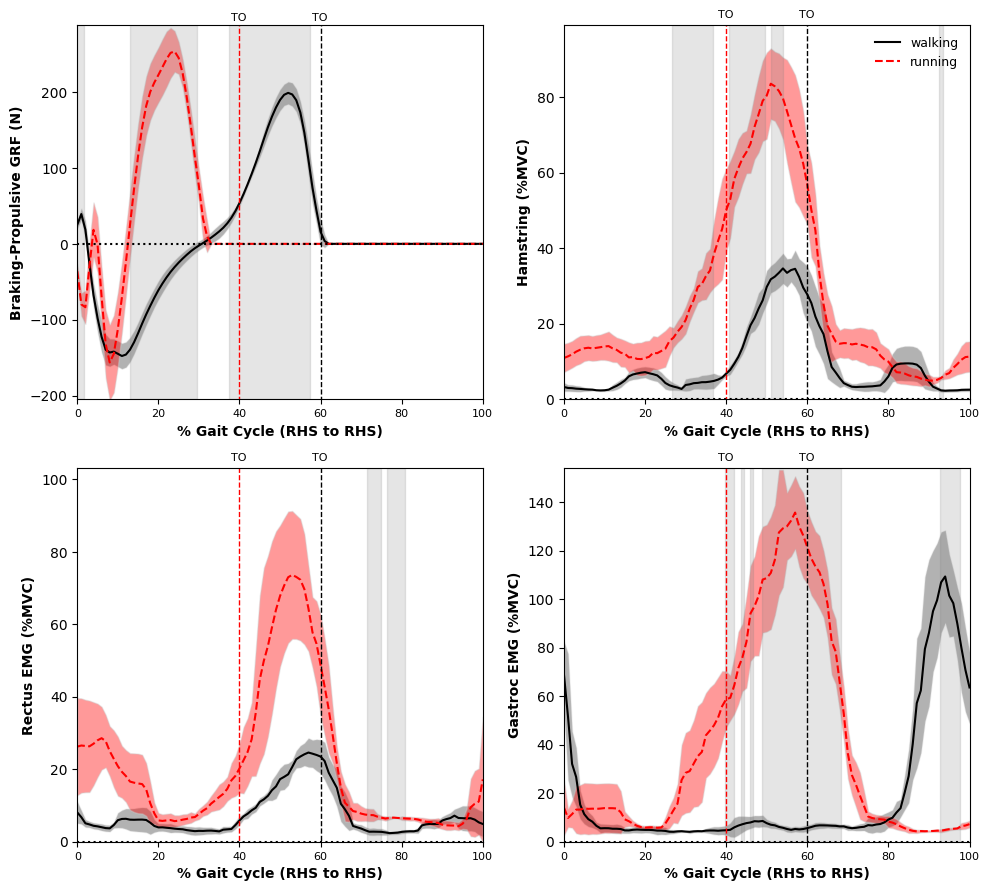

In [13]:
import spm1d
import numpy as np
import matplotlib.pyplot as pyplot

total_frames = 101
num_ticks = 6  # Number of ticks (0%, 10%, ..., 100%)

# Define a function to create each plot
def plot_spm(ax, Y1, Y2, label_Y1, label_Y2, x_label, y_label, y_limits, units, color_Y1, color_Y2, show_legend):
    spm1d.plot.plot_mean_sd(Y1, label=label_Y1, linecolor=color_Y1, facecolor=color_Y1, ax=ax, lw=1.5, alpha=0.3, autoset_ylim=False)
    spm1d.plot.plot_mean_sd(Y2, label=label_Y2, linecolor=color_Y2, facecolor=color_Y2, linestyle='--', lw=1.5, alpha=0.4, ax=ax, autoset_ylim=False)
    ax.axhline(y=0, color='k', linestyle=':')

    # --- Start of fix for zero variance error ---
    # Check for zero variance in Y1 and Y2 at each node and add tiny noise if variance is zero
    Y1_copy = Y1.copy() # Create copies to avoid modifying original global arrays directly
    Y2_copy = Y2.copy()
    for i in range(Y1_copy.shape[1]): # Iterate through each node (column)
        if np.var(Y1_copy[:, i]) == 0:
            Y1_copy[:, i] += np.random.rand(Y1_copy.shape[0]) * 1e-9 # Add tiny noise if variance is zero
        if np.var(Y2_copy[:, i]) == 0:
            Y2_copy[:, i] += np.random.rand(Y2_copy.shape[0]) * 1e-9 # Add tiny noise if variance is zero
    # --- End of fix ---

    # Conduct t-test (using ttest_paired for paired comparison):
    alpha      = 0.05
    t          = spm1d.stats.ttest_paired(Y1_copy, Y2_copy) # Pass Y1_copy and Y2_copy separately
    ti         = t.inference(alpha, two_tailed=True, interp=True)

    # Highlight suprathreshold regions
    for cluster in ti.clusters:
        start, end = cluster.endpoints
        ax.axvspan(start, end, ymin=0, ymax=1.0, color='grey', alpha=0.20)

    # Generate plots
    percentages = np.linspace(0, 100, num_ticks)  # 0%, 10%, ..., 100%
    x_ticks = (percentages / 100) * total_frames  # Normalize frame numbers
    ypos = y_limits[1] + y_limits[1]*.02          # event labels
    ax.set_xticklabels(percentages.astype(int), fontsize=8)  # Set labels as integers (0, 10%, ..., 100%)
    # ax.set_xticks(x_ticks)
    ax.vlines(x=40, ymin=y_limits[0]-100, ymax=y_limits[1]+100, color='r', linestyle='--', lw=1)
    ax.text(38, ypos, 'TO', fontsize=8)
    ax.vlines(x=60, ymin=y_limits[0]-100, ymax=y_limits[1]+100, color='k', linestyle='--', lw=1)
    ax.text(58, ypos, 'TO', fontsize=8)
    ax.set_xlabel(x_label, fontsize=10, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=10, fontweight='bold') if y_label else ax.set_ylabel("")
    ax.set_xlim(0, 100)
    ax.set_ylim(y_limits)

    if show_legend:
      ax.legend(fontsize=9, loc='upper right', frameon=False)

# Combine both SPM plots (no SPM{t} fields)
pyplot.figure( figsize=(10, 9) ) # Adjusted figsize for a 4 plot grid

# =============================================================================
# Braking-Propulsive GRF
# =============================================================================

# Replace x and y axes and filename label
xlabel = "% Gait Cycle (RHS to RHS)"
ylabel="Braking-Propulsive GRF"
units = "N"

# YA (black)
YA            = brakingprop_walking_data

# YB (red)
YB            = brakingprop_running_data

# Calculate shared y-axis limits
all_data_for_y_limits = np.concatenate((YA.flatten(), YB.flatten()))
all_data_for_y_limits = all_data_for_y_limits[~np.isnan(all_data_for_y_limits)] # remove NaNs

if len(all_data_for_y_limits) > 0:
    min_val = np.min(all_data_for_y_limits)
    max_val = np.max(all_data_for_y_limits)
    if min_val > 0:
        min_val = 0
else: # If all data is NaN after concatenation and filtering
    min_val = -1.0 # Default to some reasonable range if all data is NaN
    max_val = 1.0
y_limits = [min_val, max_val]

# Subplot 1
ax1 = pyplot.subplot(2, 2, 1) # Changed to 1 row, 3 columns, position 1
plot_spm(
    ax1, YA, YB,
    label_Y1="walking",
    label_Y2="running",
    x_label = xlabel,
    y_label=f'{ylabel} ({units})',
    y_limits=y_limits,
    units=units,
    color_Y1='k',
    color_Y2='r',
    show_legend=False
)


# =============================================================================
# Hamstring EMG
# =============================================================================

# Replace x and y axes and filename label
# xlabel = "% Gait Cycle (RHS to RHS)"
ylabel="Hamstring"
units = "%MVC"

# YA (black)
YA            = hamstring_walking_data

# YB (red)
YB            = hamstring_running_data

# Calculate shared y-axis limits
all_data_for_y_limits = np.concatenate((YA.flatten(), YB.flatten()))
all_data_for_y_limits = all_data_for_y_limits[~np.isnan(all_data_for_y_limits)] # remove NaNs

if len(all_data_for_y_limits) > 0:
    min_val = np.min(all_data_for_y_limits)
    max_val = np.max(all_data_for_y_limits)
    if min_val > 0:
        min_val = 0
else: # If all data is NaN after concatenation and filtering
    min_val = -1.0 # Default to some reasonable range if all data is NaN
    max_val = 1.0

# min_val = 0 # Removed hardcoded limits
# max_val = 1000 # Removed hardcoded limits
y_limits = [min_val, max_val] # Use dynamically calculated limits

# Subplot 2
ax2 = pyplot.subplot(2, 2, 2) # Changed to 1 row, 3 columns, position 2
plot_spm(
    ax2, YA, YB,
    label_Y1="walking",
    label_Y2="running",
    x_label = xlabel,
    y_label=f'{ylabel} ({units})',
    y_limits=y_limits,
    units=units,
    color_Y1='k',
    color_Y2='r',
    show_legend=True
)

# =============================================================================
# Rectus EMG
# =============================================================================

# Replace x and y axes and filename label
# xlabel = "% Gait Cycle (RHS to RHS)"
ylabel="Rectus EMG"
units = "%MVC"

# YA (black)
YA            = rectus_walking_data

# YB            = rectus_running_data # This line was commented out in previous execution, uncommenting it for correct execution

YB            = rectus_running_data

# Calculate shared y-axis limits
all_data_for_y_limits = np.concatenate((YA.flatten(), YB.flatten()))
all_data_for_y_limits = all_data_for_y_limits[~np.isnan(all_data_for_y_limits)] # remove NaNs

if len(all_data_for_y_limits) > 0:
    min_val = np.min(all_data_for_y_limits)
    max_val = np.max(all_data_for_y_limits)
    if min_val > 0:
        min_val = 0
else: # If all data is NaN after concatenation and filtering
    min_val = -1.0 # Default to some reasonable range if all data is NaN
    max_val = 1.0

# min_val = 0 # Removed hardcoded limits
# max_val = 1000 # Removed hardcoded limits
y_limits = [min_val, max_val] # Use dynamically calculated limits

# Subplot 3
ax3 = pyplot.subplot(2, 2, 3) # Changed to 2 rows, 2 columns, position 1
plot_spm(
    ax3, YA, YB,
    label_Y1="walking",
    label_Y2="running",
    x_label = xlabel,
    y_label=f'{ylabel} ({units})',
    y_limits=y_limits,
    units=units,
    color_Y1='k',
    color_Y2='r',
    show_legend=False
)

# =============================================================================
# Gastroc EMG
# =============================================================================

# Replace x and y axes and filename label
# xlabel = "% Gait Cycle (RHS to RHS)"
ylabel="Gastroc EMG"
units = "%MVC"

# YA (black)
YA            = gastroc_walking_data

# YB (red)
YB            = gastroc_running_data

# Calculate shared y-axis limits
all_data_for_y_limits = np.concatenate((YA.flatten(), YB.flatten()))
all_data_for_y_limits = all_data_for_y_limits[~np.isnan(all_data_for_y_limits)] # remove NaNs

if len(all_data_for_y_limits) > 0:
    min_val = np.min(all_data_for_y_limits)
    max_val = np.max(all_data_for_y_limits)
    if min_val > 0:
        min_val = 0
else: # If all data is NaN after concatenation and filtering
    min_val = -1.0 # Default to some reasonable range if all data is NaN
    max_val = 1.0

# min_val = 0 # Removed hardcoded limits
# max_val = 1000 # Removed hardcoded limits
y_limits = [min_val, max_val] # Use dynamically calculated limits

# Subplot 4
ax4 = pyplot.subplot(2, 2, 4) # Changed to 2 rows, 2 columns, position 1, now ax4
plot_spm(
    ax4, YA, YB,
    label_Y1="walking",
    label_Y2="running",
    x_label = xlabel,
    y_label=f'{ylabel} ({units})',
    y_limits=y_limits,
    units=units,
    color_Y1='k',
    color_Y2='r',
    show_legend=False
)

### plot SPM results:
pyplot.tight_layout()
pyplot.show()


# Summary Statistics

Now the discrete metrics (e.g., stride length, speed, etc.) need to be compared between conditions using traditional paired t-tests with the summary statistics displayed in an APA-formatted table.

### ✋ GenAI prompt:

Analyze the `discretes_df` to compare walking and running conditions. This involves preparing the data by extracting a unique subject identifier, calculating summary statistics (mean, standard deviation, count) for the GRF and EMG metrics grouped by condition, and performing paired t-tests for these variables between the two conditions. Finally, format these results into an APA-style table and summarize the key findings, highlighting any statistically significant differences.

### ✅ Pre-compiled code:



In [14]:
import pandas as pd
from scipy.stats import ttest_rel

# 1. Create a copy of discretes_df
discretes_for_analysis_df = discretes_df.copy()

# 2. Extract a unique subject identifier (the numerical part of the filename) from the 'filename' column
# Assuming filenames are like 'GROUP_CONDITION_SUBJECTID.txt' (e.g., Martell_TRN_04.txt -> 04)
discretes_for_analysis_df['trial_id'] = discretes_for_analysis_df['filename'].str.extract(r'_(\d+)\.txt$')[0]

# Define the desired column order
# This will effectively drop 'filename' and place 'trial_id' after 'condition'
final_columns = ['condition', 'trial_id'] + [col for col in discretes_for_analysis_df.columns if col not in ['condition', 'trial_id', 'filename']]
discretes_for_analysis_df = discretes_for_analysis_df[final_columns]

# Sort the DataFrame by 'condition' to ensure 'walking' comes before 'running'
# This uses 'walking' and 'running' as categories with a specific order
discretes_for_analysis_df['condition'] = pd.Categorical(
    discretes_for_analysis_df['condition'],
    categories=['walking', 'running'],
    ordered=True
)
discretes_for_analysis_df = discretes_for_analysis_df.sort_values(by=['condition', 'trial_id']).reset_index(drop=True)

# 3. Display the head of the discretes_for_analysis_df to verify the new 'trial_id' column and sorting
print("Head of discretes_for_analysis_df with new 'trial_id' column and sorted conditions:")
print(discretes_for_analysis_df.head())

# 4. Define a list of the variables for which summary statistics need to be calculated
summary_variables = [
        'BRAKING_GRF',
        'PROPULSIVE_GRF',
        'HAMSTRING_PERCENTMVC',
        'RECTUS_PERCENTMVC',
        'GASTROC_PERCENTMVC'
]

# 5. Group the discretes_for_analysis_df DataFrame by the 'condition' column
# 6. For each of the specified variables, calculate the mean, standard deviation, and count for each 'condition' group
summary_statistics = discretes_for_analysis_df.groupby('condition')[summary_variables].agg(
    ['mean', 'std', 'count']
)

# 7. Store these summary statistics in a new DataFrame (already done by the agg function)
# The result is automatically a DataFrame with a multi-level index/columns which is well-organized.

# 8. Display the resulting summary statistics DataFrame
print("Descriptive Statistics grouped by Condition:")
print(summary_statistics)

# 9. Define a list of the variables for which paired t-tests need to be performed
pair_ttest_variables = [
        'BRAKING_GRF',
        'PROPULSIVE_GRF',
        'HAMSTRING_PERCENTMVC',
        'RECTUS_PERCENTMVC',
        'GASTROC_PERCENTMVC'
]

# 10. Initialize a dictionary to store the t-test results
t_test_results = {}

# 11. For each variable in the defined list:
for var in pair_ttest_variables:
    # a. Filter discretes_for_analysis_df to get data for the 'walking' condition.
    walking_data = discretes_for_analysis_df[discretes_for_analysis_df['condition'] == 'walking'][['trial_id', var]]

    # b. Filter discretes_for_analysis_df to get data for the 'running' condition.
    running_data = discretes_for_analysis_df[discretes_for_analysis_df['condition'] == 'running'][['trial_id', var]]

    # c. Ensure that both filtered DataFrames contain the same 'trial_id's and are sorted by 'trial_id'
    # to guarantee correct pairing.
    merged_data = pd.merge(walking_data, running_data, on='trial_id', suffixes=('_walking', '_running'))

    # Drop rows where either walking or running data is NaN for the current variable
    merged_data = merged_data.dropna(subset=[var + '_walking', var + '_running'])

    # Extract the values for the current variable from both filtered DataFrames.
    data_walking = merged_data[var + '_walking']
    data_running = merged_data[var + '_running']

    # d. Perform a paired t-test using ttest_rel on these two sets of values.
    # Check if there are enough samples to perform the t-test
    if len(data_walking) >= 2 and len(data_running) >= 2:
        t_statistic, p_value = ttest_rel(data_walking, data_running)
    else:
        t_statistic, p_value = float('nan'), float('nan') # Set to NaN if not enough samples

    # e. Store the resulting t-statistic and p-value.
    t_test_results[var] = {'t_statistic': t_statistic, 'p_value': p_value}

# 12. Print or display the collected t-test results for each variable.
print("\nPaired t-test results (walking vs. running):")
for var, results in t_test_results.items():
    print(f"Variable: {var}")
    print(f"  t-statistic: {results['t_statistic']:.3f}")
    print(f"  p-value: {results['p_value']:.3f}")
    print("-----------------------------------------")
# 13. Initialize an empty list to store the data for the APA-style table
apa_table_data = []

# 14. Iterate through each variable in the pair_ttest_variables list
for var in pair_ttest_variables:
    # 3. For each variable, extract the mean and standard deviation for 'walking' and 'running' conditions
    #    from the summary_statistics DataFrame.
    mean_walking = summary_statistics.loc['walking', (var, 'mean')]
    std_walking = summary_statistics.loc['walking', (var, 'std')]
    mean_running = summary_statistics.loc['running', (var, 'mean')]
    std_running = summary_statistics.loc['running', (var, 'std')]

    # 4. Extract the t-statistic and p-value for the current variable from the t_test_results dictionary.
    t_stat = t_test_results[var]['t_statistic']
    p_val = t_test_results[var]['p_value']

    # 5. Create a dictionary for the current row with appropriate keys and formatted numerical values.
    row = {
        'Variable': var,
        'M \u00b1 SD (walking)': f"{mean_walking:.2f} \u00b1 {std_walking:.2f}",
         # 'SD (walking)': f"{std_walking:.2f}",
        'M \u00b1 SD (running)': f"{mean_running:.2f} \u00b1 {std_running:.2f}",
         # 'SD (running)': f"{std_running:.2f}",
         # 't': f"{t_stat:.3f}",
        'p': f"{p_val:.3f}"
    }

    # Append this row dictionary to the list.
    apa_table_data.append(row)

# 15. Create a pandas DataFrame from the list of rows.
apa_table_df = pd.DataFrame(apa_table_data)

print("APA-Style Summary and Paired t-test Results Table:")
print(apa_table_df.to_string(index=False))

Head of discretes_for_analysis_df with new 'trial_id' column and sorted conditions:
  condition trial_id  BRAKING_GRF  PROPULSIVE_GRF  HAMSTRING_PERCENTMVC  \
0   walking       01   -164.35291       185.34657              39.82803   
1   walking       02   -135.71260       192.51839              40.37548   
2   walking       03   -130.22559       198.08951              37.35354   
3   walking       04   -155.99149       223.24408              35.02448   
4   walking       05   -170.48119       197.35435              29.06403   

   RECTUS_PERCENTMVC  GASTROC_PERCENTMVC  
0           30.53542           113.12462  
1           26.96373           107.33517  
2           22.83124           131.71275  
3           26.94633            80.43238  
4           25.28177           120.95573  
Descriptive Statistics grouped by Condition:
          BRAKING_GRF                  PROPULSIVE_GRF                   \
                 mean        std count           mean        std count   
condition     

/tmp/ipython-input-3312924110.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_statistics = discretes_for_analysis_df.groupby('condition')[summary_variables].agg(


### 👏 Complete the Analysis

After you've completed this lab's analysis, do the following:

1. Copy and paste the above plots to your lab report
2. Export the tables using the code in the following cell. You can download them from your runtime directory onto your own computer.
2. Share your Colab notebook with me
3. Copy the link to your notebook and submit it along with your report for this lab on Canvas

In [15]:

import os

# Construct the full file path for the CSV file
output_filepath = os.path.join(zip_dir, f"{GROUP}_discretes_for_analysis_lab4.csv")

# Export the DataFrame to CSV
discretes_for_analysis_df.to_csv(output_filepath, index=False)

# Print a confirmation message
print(f"'discretes_for_analysis_df' exported to '{output_filepath}'")

# Construct the full file path for the CSV file
output_filepath = os.path.join(zip_dir, f"{GROUP}_summary_stats_lab4.csv")

# Export the APA formatted summary DataFrame to CSV
apa_table_df.to_csv(output_filepath, index=False)

# Print a confirmation message
print(f"'summary_statistics' exported to '{output_filepath}'")

'discretes_for_analysis_df' exported to 'kin6015/lab4/stark_discretes_for_analysis_lab4.csv'
'summary_statistics' exported to 'kin6015/lab4/stark_summary_stats_lab4.csv'
